In [1]:
# =============================================================================
# ЯЧЕЙКА 1: НАСТРОЙКА И ЗАГРУЗКА ДАННЫХ
# =============================================================================

# --- 1. Базовые импорты ---
import logging
import sys
import os
import pandas as pd
from datetime import datetime

# --- 2. Импорт для загрузки .env файла ---
from dotenv import load_dotenv

# --- 3. Импорт наших модулей ---
from htx_api import HtxApi
from trade_logger import TradeLogger
from arbitrage_strategy import TriangularArbitrageStrategy
import config

# --- 4. Настройка логирования ---
log_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('backtest.log', mode='w')
file_handler.setFormatter(log_formatter)
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(log_formatter)
stream_handler.setLevel(logging.WARNING) 
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
root_logger.handlers.clear()
root_logger.addHandler(file_handler)
root_logger.addHandler(stream_handler)
logging.getLogger('huobi').setLevel(logging.WARNING)
print("Логирование настроено. Подробный вывод в файле backtest.log")

# --- 5. Загрузка переменных из .env файла ---
load_dotenv()
print("Попытка загрузки переменных из .env файла...")

# --- 6. Загрузка ключей и инициализация API ---
API_KEY = os.getenv('API_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')
BASE_URL = os.getenv('BASE_URL')

if not all([API_KEY, SECRET_KEY, BASE_URL]):
    raise ValueError("ОШИБКА: Не удалось загрузить API_KEY, SECRET_KEY или BASE_URL. Проверьте ваш .env файл.")
else:
    print("Ключи API успешно загружены.")

htx_api = HtxApi(api_key=API_KEY, secret_key=SECRET_KEY, base_url=BASE_URL)
print("Клиент HTX API создан.")

# --- 7. Функция для загрузки и кэширования данных ---
def download_and_cache_data(api, symbols, period, size, date_str):
    """
    Загружает данные для всех символов за указанную дату из кэша.
    Если данные для хотя бы одного символа отсутствуют, скачивает
    СВЕЖИЕ данные для ВСЕХ символов и сохраняет их с ТЕКУЩЕЙ датой.
    """
    data_dir = 'historical_data'
    os.makedirs(data_dir, exist_ok=True)
    
    historical_data = {}
    all_files_exist_for_date = True
    
    # Сначала проверяем, существуют ли файлы для ВСЕХ символов за нужную дату
    for symbol in symbols:
        file_path = os.path.join(data_dir, f"{symbol}_{date_str}.csv")
        if not os.path.exists(file_path):
            all_files_exist_for_date = False
            break
            
    # Если все файлы на месте, загружаем их из кэша
    if all_files_exist_for_date:
        print(f"Загрузка данных из кэша за {date_str}...")
        for symbol in symbols:
            file_path = os.path.join(data_dir, f"{symbol}_{date_str}.csv")
            df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
            df.index = pd.to_datetime(df.index, unit='s')
            historical_data[symbol] = df
        return historical_data
        
    # Если хотя бы одного файла нет, скачиваем свежие данные для всех
    else:
        print(f"Данные за {date_str} не найдены в кэше. Загрузка свежих данных с биржи...")
        
        today_str = datetime.now().strftime('%Y-%m-%d')
        print(f"Новые данные будут сохранены с сегодняшней датой: {today_str}")
        
        for symbol in symbols:
            print(f"  - Загрузка {symbol}...")
            klines = api.get_historical_kline(symbol, period, size)
            
            if klines:
                file_path = os.path.join(data_dir, f"{symbol}_{today_str}.csv")
                df = pd.DataFrame(klines)
                df.set_index('timestamp', inplace=True)
                df.to_csv(file_path)
                
                df_loaded = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
                df_loaded.index = pd.to_datetime(df_loaded.index, unit='s')
                historical_data[symbol] = df_loaded
            else:
                print(f"Не удалось загрузить данные для {symbol}. Операция прервана.")
                return None
                
        return historical_data





Логирование настроено. Подробный вывод в файле backtest.log
Попытка загрузки переменных из .env файла...
Ключи API успешно загружены.
Клиент HTX API создан.


In [2]:
# =============================================================================
# ЯЧЕЙКА 2: ЗАПУСК БЭКТЕСТА (ИНТЕРАКТИВНАЯ ВЕРСИЯ)
# =============================================================================
from datetime import datetime
import config
from arbitrage_strategy import TriangularArbitrageStrategy
from trade_logger import TradeLogger

# --- 1. Запрашиваем дату у пользователя ---
today_str = datetime.now().strftime('%Y-%m-%d')
prompt = f"Введите дату для теста в формате ГГГГ-ММ-ДД (нажмите Enter, чтобы использовать сегодняшнюю: {today_str}): "
test_date_str = input(prompt)
if not test_date_str:
    test_date_str = today_str
print(f"Выбрана дата для теста: {test_date_str}")

# --- 2. Определяем символы и загружаем данные ---
symbols = ['btcusdt', 'ethusdt', 'ethbtc'] 
historical_data = download_and_cache_data(htx_api, symbols, '15min', 2000, test_date_str)

# --- 3. Запуск бэктеста (если данные успешно загружены) ---
if historical_data:
    print("\nЗапуск бэктеста...")
    trade_logger = TradeLogger()
    strategy = TriangularArbitrageStrategy(
        data=historical_data,
        trade_logger=trade_logger, # ИСПРАВЛЕНО: logger -> trade_logger
        min_profit_threshold=config.MIN_PROFIT_THRESHOLD,
        position_size=config.POSITION_SIZE,
        fee_rate=0.002 
    )

    # --- 4. Запуск и обработка результатов ---
    print("-" * 80)
    found_opportunities = 0
    total_profit = 0
    trade_timestamps = []    # Список для сбора времени сделок
    profit_percentages = []  # НОВОЕ: Список для сбора процентов прибыли

    for trade_details in strategy.run():
        found_opportunities += 1
        
        # Собираем данные для графиков и гистограммы
        trade_timestamps.append(trade_details['timestamp'])
        profit_percentages.append(trade_details['profit_percent']) # НОВОЕ: Добавляем профит в список
        
        # Выводим детальную информацию о сделке
        print(f"\n✅ НАЙДЕНА ВОЗМОЖНОСТЬ #{found_opportunities}")
        print(f"   Время: {trade_details['timestamp']}")
        print(f"   Путь: {trade_details['path_name']}")
        print(f"   Профит: \033[92m{trade_details['profit_percent']:.4f}%\033[0m")
        print("   --- Детализация шагов ---")
        
        initial_amount = trade_details['initial_amount']
        step1, step2, step3 = trade_details['steps']
        
        print(f"   1. {step1['operation'].upper()} {step1['symbol']} @ {step1['rate']:.8f} | {initial_amount:.2f} USDT -> {step1['amount_after']:.8f}")
        print(f"   2. {step2['operation'].upper()} {step2['symbol']} @ {step2['rate']:.8f} | {step1['amount_after']:.8f} -> {step2['amount_after']:.8f}")
        print(f"   3. {step3['operation'].upper()} {step3['symbol']} @ {step3['rate']:.8f} | {step2['amount_after']:.8f} -> {step3['amount_after']:.2f} USDT")
        print("-" * 80)

        profit_amount = step3['amount_after'] - initial_amount
        total_profit += profit_amount

    # --- 5. Итоговая статистика ---
    print(f"\nБэктест завершен.")
    print(f"Всего найдено возможностей: {found_opportunities}")
    final_balance = config.POSITION_SIZE + total_profit
    color_code = "\033[92m" if total_profit >= 0 else "\033[91m"
    print(f"Начальный баланс: {config.POSITION_SIZE:.4f} USDT")
    print(f"Итоговый баланс: {color_code}{final_balance:.4f} USDT\033[0m")
    print(f"Общая чистая прибыль: {color_code}{total_profit:+.4f} USDT\033[0m")

else:
    print("Бэктест не может быть запущен, так как данные не были загружены.")

Выбрана дата для теста: 2025-08-02
Загрузка данных из кэша за 2025-08-02...

Запуск бэктеста...
2025-08-03 15:17:00,019 - arbitrage_strategy - WARNING - API клиент не предоставлен. Используются комиссии по умолчанию.
--------------------------------------------------------------------------------


/tmp/ipykernel_17896/3410024438.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
/tmp/ipykernel_17896/3410024438.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
/tmp/ipykernel_17896/3410024438.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)



Бэктест завершен.
Всего найдено возможностей: 0
Начальный баланс: 15.0000 USDT
Итоговый баланс: 15.0000 USDT
Общая чистая прибыль: +0.0000 USDT


In [3]:
# =============================================================================
# ЯЧЕЙКА 2.5: ДИАГНОСТИКА ЗАГРУЖЕННЫХ ДАННЫХ
# =============================================================================
print("🕵️  Проводим диагностику загруженных данных...\n")

if 'historical_data' in locals() and historical_data:
    # 1. Проверяем "хвосты" каждого датафрейма, чтобы увидеть временные метки
    for symbol, df in historical_data.items():
        print(f"--- Данные для: {symbol} ---")
        print(f"Количество строк: {len(df)}")
        if not df.empty:
            print("Первые 3 строки:")
            print(df.head(3))
            print("\nПоследние 3 строки:")
            print(df.tail(3))
        print("-" * 30 + "\n")

    # 2. Объединяем данные БЕЗ .dropna() чтобы увидеть пропуски
    print("\n🕵️  Объединяем данные БЕЗ удаления строк с пропусками (чтобы увидеть NaN)...\n")
    df_list_debug = [df.add_prefix(f'{symbol}_') for symbol, df in historical_data.items()]
    combined_df_debug = pd.concat(df_list_debug, axis=1)

    print("--- Объединенные данные (первые 5 строк) ---")
    print(combined_df_debug.head())
    print("\n--- Объединенные данные (последние 5 строк) ---")
    print(combined_df_debug.tail())

    # 3. Считаем, сколько пропусков (NaN) в каждой колонке
    print("\n🕵️  Количество пропусков (NaN) в каждой колонке объединенного датафрейма:\n")
    print(combined_df_debug.isnull().sum())
    
    # 4. Проверяем, есть ли хоть одна строка без пропусков
    rows_without_nan = combined_df_debug.dropna().shape[0]
    print(f"\n\n✅ Итоговое количество строк БЕЗ пропусков: {rows_without_nan}")
    if rows_without_nan == 0:
        print("\n\033[91mДИАГНОЗ: Не найдено ни одной временной метки, где данные присутствуют для всех 3 пар одновременно.\033[0m")
        print("\033[93mЭто основная причина, по которой анализ не находит точек для построения гистограммы.\033[0m")

else:
    print("\033[91mПеременная 'historical_data' не найдена. Убедитесь, что Ячейка №2 была выполнена успешно.\033[0m")


🕵️  Проводим диагностику загруженных данных...

--- Данные для: btcusdt ---
Количество строк: 2000
Первые 3 строки:
                          open      close       high        low            vol
timestamp                                                                     
2025-08-02 09:09:00  113763.99  113750.01  113763.99  113750.01    4242.821658
2025-08-02 09:08:00  113760.87  113770.47  113770.48  113760.87    7032.929946
2025-08-02 09:07:00  113744.01  113764.99  113765.00  113744.01  119086.269604

Последние 3 строки:
                         open      close       high        low            vol
timestamp                                                                    
2025-07-31 23:52:00  115715.0  115680.00  115715.00  115660.00   57704.082630
2025-07-31 23:51:00  115820.0  115715.00  115834.99  115715.00  427894.728284
2025-07-31 23:50:00  115830.0  115809.56  115879.02  115809.56  208835.407413
------------------------------

--- Данные для: ethusdt ---
Количество строк: 

In [4]:

   # =============================================================================
   # ЯЧЕЙКА 3: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
   # =============================================================================
   import matplotlib.pyplot as plt
   import matplotlib.dates as mdates

   if not trade_timestamps:
       print("Не найдено арбитражных возможностей для визуализации.")
   else:
       print(f"\nВизуализация {len(trade_timestamps)} найденных сделок на графиках...")
       
       fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=True)
       fig.suptitle(f'Арбитражные возможности за {test_date_str}', fontsize=16)
       
       symbols_to_plot = ['btcusdt', 'ethusdt', 'ethbtc']
       
       for i, symbol in enumerate(symbols_to_plot):
           ax = axes[i]
           price_data = historical_data[symbol]
           ax.plot(price_data.index, price_data['close'], label=f'Цена {symbol.upper()}', color='dodgerblue')
           
           for ts in trade_timestamps:
               ax.axvline(ts, color='red', linestyle='--', linewidth=0.8)

           # Добавляем одну метку для всех вертикальных линий
           if trade_timestamps:
                ax.plot([], [], color='red', linestyle='--', linewidth=0.8, label='Момент сделки')

           ax.set_title(f'График {symbol.upper()}', fontsize=12)
           ax.set_ylabel('Цена')
           ax.grid(True, linestyle='--', alpha=0.6)
           ax.legend()

       axes[-1].set_xlabel('Время')
       fig.autofmt_xdate()
       plt.tight_layout(rect=[0, 0, 1, 0.96])
       plt.show()

Не найдено арбитражных возможностей для визуализации.


In [5]:
# =============================================================================
# ЯЧЕЙКА 4: ГИСТОГРАММА РАСПРЕДЕЛЕНИЯ ПРИБЫЛЬНОСТИ
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

if profit_percentages:
    plt.style.use('seaborn-v0_8-darkgrid') # Используем красивый стиль
    fig, ax = plt.subplots(figsize=(12, 6))

    # Строим гистограмму
    ax.hist(profit_percentages, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

    # Добавляем среднее значение и медиану для анализа
    mean_profit = np.mean(profit_percentages)
    median_profit = np.median(profit_percentages)
    
    ax.axvline(mean_profit, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_profit:.4f}%')
    ax.axvline(median_profit, color='green', linestyle='dashed', linewidth=2, label=f'Медиана: {median_profit:.4f}%')

    # Настройка заголовков и меток
    ax.set_title(f'Гистограмма распределения прибыльности ({found_opportunities} сделок)', fontsize=16)
    ax.set_xlabel('Процент прибыли (%)', fontsize=12)
    ax.set_ylabel('Частота (количество сделок)', fontsize=12)
    ax.legend()
    
    # Улучшаем читаемость оси X
    plt.xticks(rotation=45)
    plt.tight_layout() # Автоматически подгоняет элементы графика
    plt.show()
else:
    print("Не найдено арбитражных возможностей для построения гистограммы.")


Не найдено арбитражных возможностей для построения гистограммы.


Запуск анализа всех рыночных расхождений...
Данные для анализа загружены. Количество временных рядов: 3
Анализ завершен. Найдено 1999 точек данных для анализа.


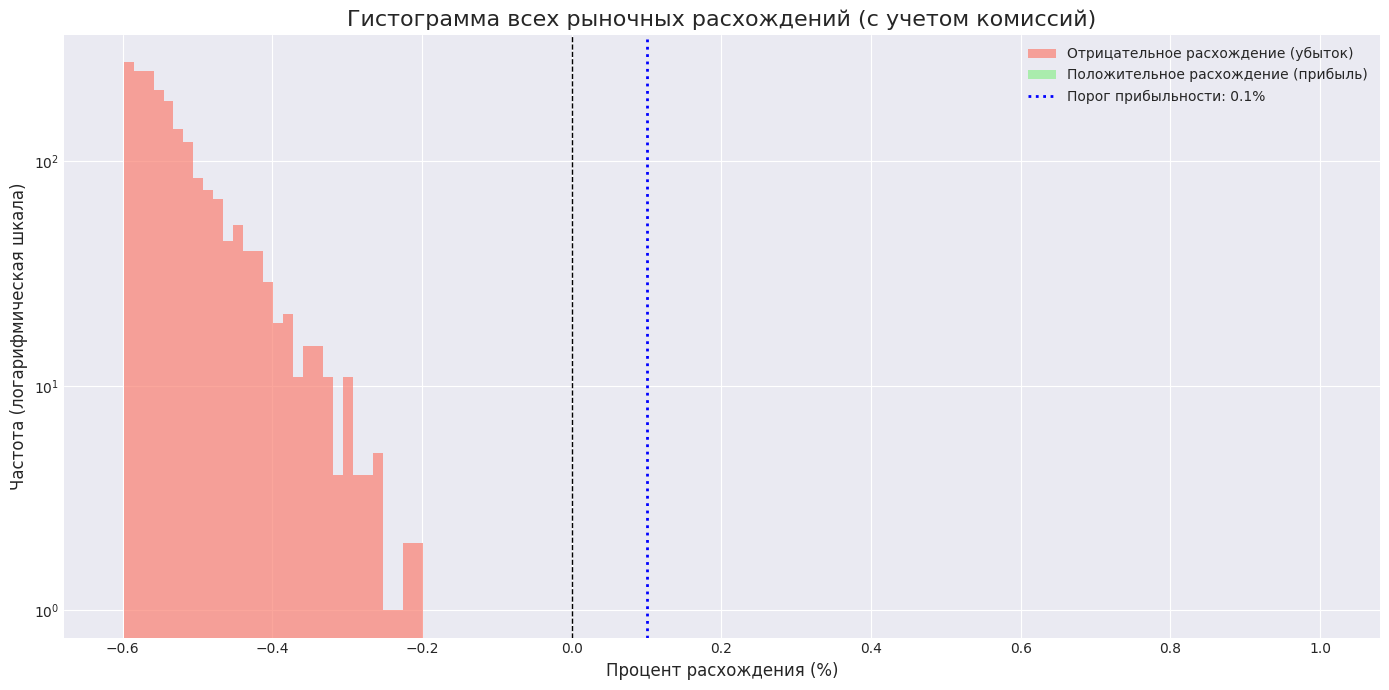

In [6]:
# =============================================================================
# ЯЧЕЙКА 5: ГИСТОГРАММА ВСЕХ РАСХОЖДЕНИЙ (КАК В ИНДИКАТОРЕ)
# =============================================================================

print("Запуск анализа всех рыночных расхождений...")

# --- ОТЛАДКА: Проверяем, что данные в стратегии вообще есть ---
if not strategy.data:
    print("\033[91mОШИБКА: В объекте стратегии отсутствуют исторические данные. Проверьте Ячейку №2.\033[0m")
else:
    print(f"Данные для анализа загружены. Количество временных рядов: {len(strategy.data)}")

    # 1. Собираем данные о всех расхождениях
    all_divergences = []
    # Используем новый метод, который не зависит от порога прибыльности
    for result in strategy.run_divergence_analysis():
        all_divergences.append(result['profit_percent'])

    print(f"Анализ завершен. Найдено {len(all_divergences)} точек данных для анализа.")

    # 2. Строим гистограмму, если данные есть
    if all_divergences:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(14, 7))

        # Разделяем данные на положительные и отрицательные для разного цвета
        positive_divergences = [d for d in all_divergences if d >= 0]
        negative_divergences = [d for d in all_divergences if d < 0]

        # Строим гистограммы
        ax.hist(negative_divergences, bins=30, color='salmon', alpha=0.7, label='Отрицательное расхождение (убыток)')
        ax.hist(positive_divergences, bins=30, color='lightgreen', alpha=0.7, label='Положительное расхождение (прибыль)')
        
        # Добавляем вертикальную линию на нуле
        ax.axvline(0, color='black', linestyle='--', linewidth=1)

        # Добавляем линию порога прибыльности для контекста
        ax.axvline(config.MIN_PROFIT_THRESHOLD, color='blue', linestyle='dotted', linewidth=2, 
                    label=f'Порог прибыльности: {config.MIN_PROFIT_THRESHOLD}%')

        # Настройка заголовков и меток
        ax.set_title('Гистограмма всех рыночных расхождений (с учетом комиссий)', fontsize=16)
        ax.set_xlabel('Процент расхождения (%)', fontsize=12)
        ax.set_ylabel('Частота', fontsize=12)
        ax.legend()
        
        # Устанавливаем логарифмическую шкалу для оси Y, чтобы лучше видеть редкие события
        if len(all_divergences) > 100:
            ax.set_yscale('log')
            ax.set_ylabel('Частота (логарифмическая шкала)', fontsize=12)

        plt.tight_layout()
        plt.show()
    else:
        print("\033[93mНе удалось собрать данные о расхождениях. Вероятная причина: нет временных точек, где данные существуют для всех 3 пар одновременно.\033[0m")
        print("\033[93mПОПРОБУЙТЕ ВЫБРАТЬ ДРУГУЮ ДАТУ ДЛЯ ТЕСТА В ЯЧЕЙКЕ №2.\033[0m")

